<a href="https://colab.research.google.com/github/Jackelyneg/covid-19-image-classification/blob/main/xraymodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os;
import datetime  
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
%matplotlib inline
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/archive (1).zip" -d "/content/drive/MyDrive/Colab Notebooks/data"


ls to see the names of the folder

In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/data/dataset"

covid  normal


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Generating Dataset

In [ ]:
# the training dataset
training_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/data/dataset",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    #batch_size=32,
    #image_size=(256, 256),
    shuffle=True,
    seed=123,#
    validation_split=0.2,
    subset="training",#to divide the dataset into training
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 94 files belonging to 2 classes.
Using 76 files for training.


In [ ]:
# the testing/validation Dataset
val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/data/dataset",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    #batch_size=32,
    #image_size=(256, 256),
    shuffle=True,
    seed=123,#
    validation_split=0.2,
    subset="validation",#to divide the dataset into training
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
        image_size=(img_height, img_width),
  batch_size=batch_size
)


Found 94 files belonging to 2 classes.
Using 18 files for validation.


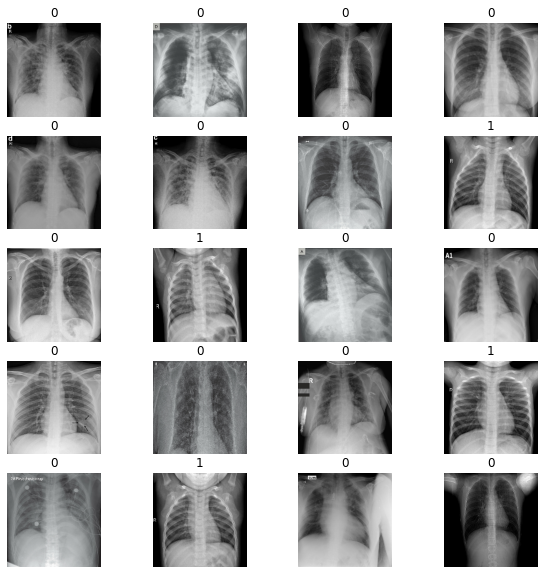

In [ ]:
#trying to visualize the first 20 images in training dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
val_dataset

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

We are configuring the dataset here. Dataset Cache is used to keep images in memory after first epoch.

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
AUTOTUNE = tf.data.AUTOTUNE

training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data.
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer.

In [ ]:
from tensorflow.keras import layers
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [ ]:
from tensorflow.keras.models import Sequential
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [ ]:
epochs=5
history = model.fit(
  training_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

Epoch 1/5
3/3 [==============================] - 7s 2s/step - loss: 1.5096 - accuracy: 0.4079 - val_loss: 0.6894 - val_accuracy: 0.6667
Epoch 2/5
3/3 [==============================] - 2s 753ms/step - loss: 0.6326 - accuracy: 0.7237 - val_loss: 0.5222 - val_accuracy: 0.8889
Epoch 3/5
3/3 [==============================] - 2s 1s/step - loss: 0.4533 - accuracy: 0.7895 - val_loss: 0.5430 - val_accuracy: 0.6667
Epoch 4/5
3/3 [==============================] - 2s 1s/step - loss: 0.3667 - accuracy: 0.8158 - val_loss: 0.3070 - val_accuracy: 1.0000
Epoch 5/5
3/3 [==============================] - 2s 762ms/step - loss: 0.2666 - accuracy: 0.9474 - val_loss: 0.2051 - val_accuracy: 1.0000


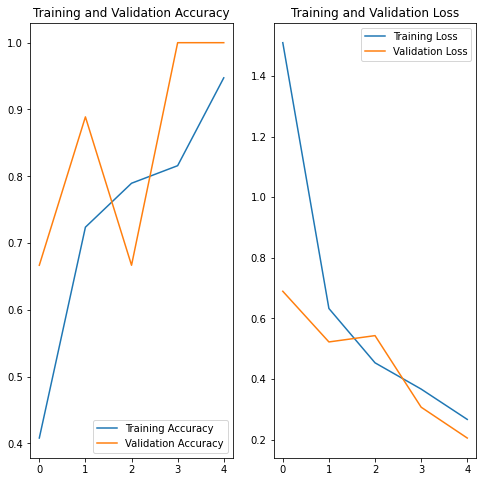

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
df = tfds.as_dataframe(training_dataset.take(10)#)


SyntaxError: ignored

In [ ]:
tfds.as_dataframe(
    training_dataset,
    Optional[tfds.core.DatasetInfo] = None
) -> StyledDataFrame

SyntaxError: ignored

In [ ]:
augmented_train_ds = training_dataset.map(
  lambda x, y: (data_augmentation(x, training=True), y))

NameError: ignored

In [ ]:
covid_paths=[]
for name in glob('/content/drive/MyDrive/Colab Notebooks/data/dataset/covid/*',recursive=True):
    covid_paths.append(name)
print(len(covid_paths))

69


In [ ]:
normal_paths=[]
for name in glob('/content/drive/MyDrive/Colab Notebooks/data/dataset/normal/*',recursive=True):
    normal_paths.append(name)
print(len(normal_paths))

25


In [ ]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        img = cv2.imread(i ,cv2.IMREAD_COLOR)
        img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
        img_arrays.append([img_sized, label])
    return img_arrays

In [ ]:
class0_array = get_image_arrays(normal_paths, 0)
class1_array = get_image_arrays(covid_paths, 1)

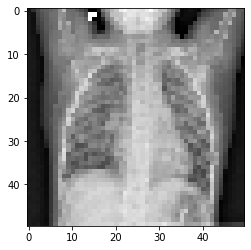

In [ ]:
plt.imshow(class0_array[0][0])

In [ ]:
combined_data = np.concatenate((class0_array, class1_array))


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)

In [ ]:
X = np.array(X).reshape(-1, 50, 50, 3)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70, 50, 50, 3) (24, 50, 50, 3) (70, 2) (24, 2)


In [ ]:
import tensorflow as tf
from tensorflow import keras


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=100, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(50,50,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(2,2), strides=(2,2), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(9216,input_shape=(12544,), activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='sigmoid')
])

In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall','Precision']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history=model.fit(X_train,y_train, validation_data=(X_test, y_test),epochs=16)

Epoch 1/16
3/3 [==============================] - 6s 2s/step - loss: 0.7216 - accuracy: 0.7143 - recall: 0.6857 - precision: 0.7059 - val_loss: 0.6108 - val_accuracy: 0.7083 - val_recall: 0.7083 - val_precision: 0.7083
Epoch 2/16
3/3 [==============================] - 4s 1s/step - loss: 0.7102 - accuracy: 0.7571 - recall: 0.7286 - precision: 0.7286 - val_loss: 0.6203 - val_accuracy: 0.7083 - val_recall: 0.7083 - val_precision: 0.7083
Epoch 3/16
3/3 [==============================] - 4s 1s/step - loss: 0.5915 - accuracy: 0.7429 - recall: 0.7429 - precision: 0.7429 - val_loss: 0.6291 - val_accuracy: 0.7083 - val_recall: 0.7083 - val_precision: 0.7083
Epoch 4/16
3/3 [==============================] - 4s 1s/step - loss: 0.7256 - accuracy: 0.7286 - recall: 0.6000 - precision: 0.7119 - val_loss: 0.6360 - val_accuracy: 0.7083 - val_recall: 0.7083 - val_precision: 0.7083
Epoch 5/16
3/3 [==============================] - 4s 1s/step - loss: 0.7029 - accuracy: 0.6857 - recall: 0.6714 - precision:

In [ ]:
e=model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 194ms/step - loss: 0.6633 - accuracy: 0.6667 - recall: 0.6250 - precision: 0.6818
